In [1]:
import nltk
from nltk.corpus import wordnet as wn
import pickle
import pandas as pd
import numpy as np
import random
import os
import pandas as pd
from scipy.spatial.distance import cosine
import re
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [2]:
base_dir = "/Users/bhuvan/Documents/MS/MSU/nlp/project/data/sgns"
decades   = [str(y) for y in range(1800, 2000, 10)]

vocab_by_decade = {}
for d in decades:
    with open(os.path.join(base_dir, f"{d}-vocab.pkl"), "rb") as f:
        vocab_by_decade[d] = pickle.load(f)

top_k = 5000 # extract top 5000 words from each decade
freq_candidates = set()                     
for d in decades:                           
    freq_candidates.update(vocab_by_decade[d][:top_k])


common = [
    w for w in freq_candidates
    if all(w in vocab_by_decade[d] for d in decades)
] # filter out only words common to all decades


poly_ok = [
    w for w in common
    if len(wn.synsets(w, pos=wn.NOUN)) <= 10
] # filter out words with polysemy density greater than 10


clean = [w for w in poly_ok if "-" not in w and "_" not in w and not re.search(r"\d", w) and "." not in w] # filter out words with noise


domain_map = {
    'technology'    : {'noun.artifact', 'noun.machine', 'noun.communication'},
    'everyday'      : {'noun.food', 'noun.person', 'noun.substance'},
    'scientific'    : {'noun.cognition', 'noun.attribute', 'noun.process'},
    'arts_culture'  : {'noun.act', 'noun.communication'},
    'emotion_social': {'noun.state', 'noun.feeling', 'noun.group'},
    'business_econ' : {'noun.possession', 'noun.quantity'},
    'geo_places'    : {'noun.location'},
    'time_measure'  : {'noun.time', 'noun.dimension'},
    'sport_leisure' : {'noun.event'},
    'medical_health': {'noun.body', 'noun.tops'}
}

buckets = {dom: [] for dom in domain_map}

for w in clean:
    syns = wn.synsets(w, pos=wn.NOUN)
    if not syns:
        continue
    lex = syns[0].lexname()
    for dom, lexset in domain_map.items():
        if lex in lexset:
            buckets[dom].append(w)
            break
targets = list(set().union(*buckets.values()))  # Words in all domains

random.shuffle(targets)
pd.DataFrame({'word': targets}).to_csv('targets.csv', index=False)
print("targets.csv written")
for dom, words in buckets.items():
    print(f"{dom:15s}: {len(words)} words")
print(f"TOTAL targets: {len(targets)}")

models = {}
for d in decades:
    mat = np.load(os.path.join(base_dir, f"{d}-w.npy"))
    vocab = vocab_by_decade[d]
    models[d] = {w: mat[i] for i, w in enumerate(vocab) if w in targets} # keeps only vectors for words in targets.csv

with open("target_vectors.pkl", "wb") as f:
    pickle.dump(models, f)
print("Picked vectors saved to target_vectors.pkl")

targets.csv written
technology     : 906 words
everyday       : 861 words
scientific     : 689 words
arts_culture   : 523 words
emotion_social : 638 words
business_econ  : 246 words
geo_places     : 268 words
time_measure   : 134 words
sport_leisure  : 126 words
medical_health : 96 words
TOTAL targets: 4487
Picked vectors saved to target_vectors.pkl


In [3]:
targets = pd.read_csv('targets.csv')['word'].tolist()

density = [] # computes the polysemy density of each word in targets
for w in targets:
    n_senses = len(wn.synsets(w, pos=wn.NOUN)) # wordnet is used to compute density
    density.append({'word': w, 'polysemy_density': n_senses})

df = pd.DataFrame(density)
df.to_csv('polysemy_density.csv', index=False)
print(df.head())
print("\nSaved polysemy_density.csv with", len(df), "rows")

      word  polysemy_density
0  contact                 9
1  binding                 5
2      dna                 1
3     arts                 5
4       he                 2

Saved polysemy_density.csv with 4487 rows


In [4]:
with open("target_vectors.pkl", "rb") as f: # openss the target vectors file
    vectors = pickle.load(f)

decades = sorted(vectors.keys())         
targets = list(next(iter(vectors.values())).keys())  


def safe_cosine(u, v): # Function to calculate cosine distance
    nu, nv = np.linalg.norm(u), np.linalg.norm(v)
    return cosine(u, v) if nu > 0 and nv > 0 else np.nan


records = []
for w in targets:
    vecs = [vectors[d][w] for d in decades]
    dists = [safe_cosine(u, v) for u, v in zip(vecs, vecs[1:])]
    dists = [d for d in dists if not np.isnan(d)]
    avg_drift = np.mean(dists) if dists else np.nan # Compute the mean cosine distance
    records.append({'word': w, 'drift_rate': avg_drift})

drift_df = pd.DataFrame(records).dropna()
drift_df.to_csv("semantic_drift.csv", index=False)
print(drift_df.head())
print(f"\nSaved semantic_drift.csv with {len(drift_df)} rows")

  word  drift_rate
0   in    0.494935
1    a    0.457885
2   it    0.395511
3   be    0.357059
4   as    0.456464

Saved semantic_drift.csv with 4487 rows


4487 words for analysis
Pearson r=-0.188, p=4.71e-37
R²=0.035,  slope=-0.00536


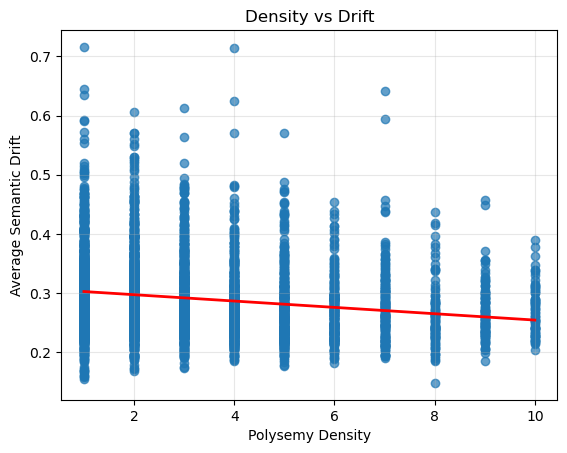

In [5]:
dens = pd.read_csv('polysemy_density.csv')
drft = pd.read_csv('semantic_drift.csv')
df = pd.merge(dens, drft, on='word').dropna()
print(f"{len(df)} words for analysis")

# Pearson r
r, p = pearsonr(df['polysemy_density'], df['drift_rate'])
print(f"Pearson r={r:.3f}, p={p:.3g}")

# Linear Regression
X = df[["polysemy_density"]]
y = df["drift_rate"]
lm = LinearRegression().fit(X, y)
print(f"R²={lm.score(X,y):.3f},  slope={lm.coef_[0]:.5f}")

# Scatter plot for Density vs Drift
plt.scatter(df["polysemy_density"], y, alpha=0.7)
xs = pd.DataFrame({"polysemy_density":
                   np.linspace(X.min().item(), X.max().item(), 100)})
plt.plot(xs["polysemy_density"],
         lm.predict(xs), "r-", linewidth=2)
plt.xlabel("Polysemy Density")
plt.ylabel("Average Semantic Drift")
plt.title("Density vs Drift")
plt.grid(alpha=.3)
plt.show()